#### Parameter Estimation 2

Here we work through an example of Kinetic Parameter Estimation.

First we simulate the kinematic behaviour

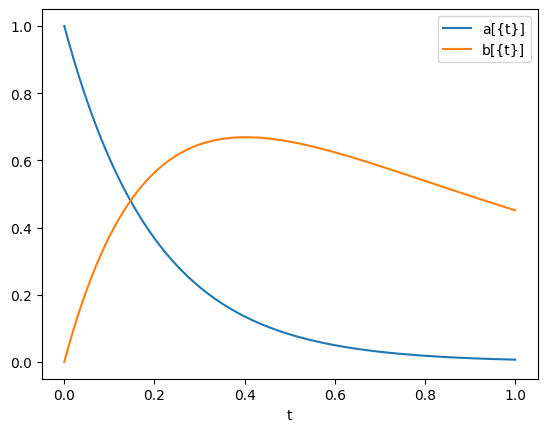

In [1]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar, Simulator
import scipy

m = pyo.ConcreteModel()

m.t = ContinuousSet(bounds=(0,1))
m.a = pyo.Var(m.t)
m.b = pyo.Var(m.t)

m.k1 = pyo.Param(initialize=5)
m.k2 = pyo.Param(initialize=1)

m.dadt = DerivativeVar(m.a)
m.dbdt = DerivativeVar(m.b)

m.a[0].fix(1)
m.b[0].fix(0)

def _da(m, t):
    return m.dadt[t] == -m.k1*m.a[t]
m.da_con = pyo.Constraint(m.t, rule=_da)

def _db(m, t):
    return m.dbdt[t] == m.k1*m.a[t] - m.k2*m.b[t]
m.db_con = pyo.Constraint(m.t, rule=_db)

mysim = Simulator(m, package='scipy')
tsim, profiles = mysim.simulate(integrator='vode', numpoints=100)

import matplotlib.pyplot as plt

varorder = mysim.get_variable_order()
for idx, v in enumerate(varorder):
    plt.plot(tsim, profiles[:, idx], label=v)

plt.xlabel('t')
plt.legend(loc='best')
plt.show()

plt.show()


Now let's estimate the parameters

In [2]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar

a_conc = {0.1:0.606, 0.2:0.368, 0.3:0.223, 0.4:0.135, 0.5:0.082,
          0.6:0.05, 0.7:0.03, 0.8:0.018, 0.9:0.011, 1.0:0.007}

b_conc = {0.1:0.373, 0.2:0.564, 0.3:0.647, 0.4:0.669, 0.5:0.656,
          0.6:0.624, 0.7:0.583, 0.8:0.539, 0.9:0.494, 1.0:0.451}

m = pyo.ConcreteModel()

m.meas_time = pyo.Set(initialize=sorted(a_conc.keys()),ordered=True)
m.ameas = pyo.Param(m.meas_time, initialize=a_conc)
m.bmeas = pyo.Param(m.meas_time, initialize=b_conc)

m.time = ContinuousSet(initialize=m.meas_time, bounds=(0,1))

m.a = pyo.Var(m.time, bounds=(0,1))
m.b = pyo.Var(m.time, bounds=(0,1))

m.dadt = DerivativeVar(m.a)
m.dbdt = DerivativeVar(m.b)

m.k1 = pyo.Var()
m.k2 = pyo.Var()

def _a_diffeq(m,t):
    return m.dadt[t] == -m.k1*m.a[t]
m.a_diffeq = pyo.Constraint(m.time, rule=_a_diffeq)

def _b_diffeq(m,t):
    return m.dbdt[t] == m.k1*m.a[t] - m.k2*m.b[t]
m.b_diffeq = pyo.Constraint(m.time, rule=_b_diffeq)

m.ainit = pyo.Constraint(expr=m.a[0]==1)
m.binit = pyo.Constraint(expr=m.b[0]==0)

def _obj(m):
    return sum((m.a[t]-m.ameas[t])**2+(m.b[t]-m.bmeas[t])**2 for t in m.meas_time)
m.obj = pyo.Objective(rule=_obj)

discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=10,ncp=3,scheme='LAGRANGE-RADAU')

ipopt_runner_path = "/home/runner/work/pyomo_jupyter_book/pyomo_jupyter_book/solvers/ipopt"
solver = pyo.SolverFactory('ipopt', executable=ipopt_runner_path)
solver.solve(m, tee=True)

print('k1= '+str(pyo.value(m.k1)))
print('k2= '+str(pyo.value(m.k2)))

meas_time = list(m.meas_time)
a_meas = [pyo.value(m.ameas[i]) for i in m.meas_time]
b_meas = [pyo.value(m.bmeas[i]) for i in m.meas_time]

t = list(m.time)
a = [pyo.value(m.a[i]) for i in m.time]
b = [pyo.value(m.b[i]) for i in m.time]
    
import matplotlib.pyplot as plt

plt.plot(t,a,label='A')
plt.plot(t,b,label='B')
plt.plot(meas_time,a_meas,'o')
plt.plot(meas_time,b_meas,'o')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('concentration')
plt.title('Kinetic Parameter Estimation')
plt.show()


for solver ipopt. File with
name=/home/runner/work/pyomo_jupyter_book/pyomo_jupyter_book/solvers/ipopt
either does not exist or it is not executable. To skip this validation, call
set_executable with validate=False.
Traceback (most recent call last):
  File "/home/runner/.local/lib/python3.12/site-packages/pyomo/opt/base/solvers.py", line 148, in __call__
    opt = self._cls[_name](**kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/runner/.local/lib/python3.12/site-packages/pyomo/solvers/plugins/solvers/IPOPT.py", line 44, in __init__
    super(IPOPT, self).__init__(**kwds)
  File "/home/runner/.local/lib/python3.12/site-packages/pyomo/opt/solver/shellcmd.py", line 66, in __init__
    self.set_executable(name=executable, validate=validate)
  File "/home/runner/.local/lib/python3.12/site-packages/pyomo/opt/solver/shellcmd.py", line 115, in set_executable
    raise ValueError(
ValueError: Failed to set executable for solver ipopt. File with name=/home/runner/work/pyomo_jupyter_book

RuntimeError: Attempting to use an unavailable solver.

The SolverFactory was unable to create the solver "ipopt"
and returned an UnknownSolver object.  This error is raised at the point
where the UnknownSolver object was used as if it were valid (by calling
method "solve").

The original solver was created with the following parameters:
	executable: /home/runner/work/pyomo_jupyter_book/pyomo_jupyter_book/solvers/ipopt
	type: ipopt
	_args: ()
	options: {}

Ipopt 3.9.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Common Public License (CPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.9.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      550
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       82

Total number of variables............................:      126
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       62
   

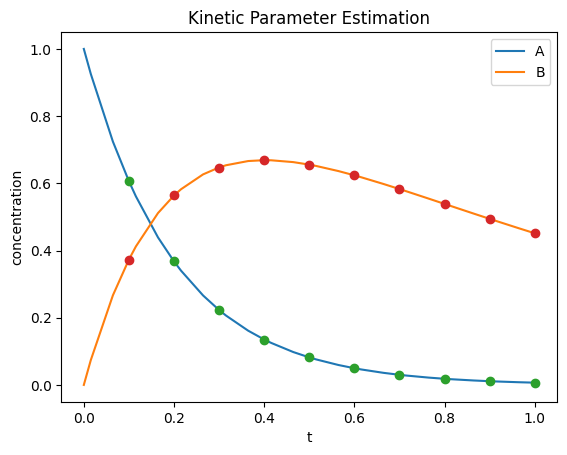

In [3]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar

a_conc = {0.1:0.606, 0.2:0.368, 0.3:0.223, 0.4:0.135, 0.5:0.082,
          0.6:0.05, 0.7:0.03, 0.8:0.018, 0.9:0.011, 1.0:0.007}

b_conc = {0.1:0.373, 0.2:0.564, 0.3:0.647, 0.4:0.669, 0.5:0.656,
          0.6:0.624, 0.7:0.583, 0.8:0.539, 0.9:0.494, 1.0:0.451}

m = pyo.ConcreteModel()

m.meas_time = pyo.Set(initialize=sorted(a_conc.keys()),ordered=True)
m.ameas = pyo.Param(m.meas_time, initialize=a_conc)
m.bmeas = pyo.Param(m.meas_time, initialize=b_conc)

m.time = ContinuousSet(initialize=m.meas_time, bounds=(0,1))

m.a = pyo.Var(m.time, bounds=(0,1))
m.b = pyo.Var(m.time, bounds=(0,1))

m.dadt = DerivativeVar(m.a)
m.dbdt = DerivativeVar(m.b)

m.k1 = pyo.Var()
m.k2 = pyo.Var()

def _a_diffeq(m,t):
    return m.dadt[t] == -m.k1*m.a[t]
m.a_diffeq = pyo.Constraint(m.time, rule=_a_diffeq)

def _b_diffeq(m,t):
    return m.dbdt[t] == m.k1*m.a[t] - m.k2*m.b[t]
m.b_diffeq = pyo.Constraint(m.time, rule=_b_diffeq)

m.ainit = pyo.Constraint(expr=m.a[0]==1)
m.binit = pyo.Constraint(expr=m.b[0]==0)

def _obj(m):
    return sum((m.a[t]-m.ameas[t])**2+(m.b[t]-m.bmeas[t])**2 for t in m.meas_time)
m.obj = pyo.Objective(rule=_obj)

discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=10,ncp=3,scheme='LAGRANGE-RADAU')

ipopt_runner_path = "/home/runner/work/pyomo_jupyter_book/pyomo_jupyter_book/solvers/ipopt"
solver = pyo.SolverFactory('ipopt', executable=ipopt_runner_path)
solver.solve(m, tee=True)

print('k1= '+str(pyo.value(m.k1)))
print('k2= '+str(pyo.value(m.k2)))

meas_time = list(m.meas_time)
a_meas = [pyo.value(m.ameas[i]) for i in m.meas_time]
b_meas = [pyo.value(m.bmeas[i]) for i in m.meas_time]

t = list(m.time)
a = [pyo.value(m.a[i]) for i in m.time]
b = [pyo.value(m.b[i]) for i in m.time]
    
import matplotlib.pyplot as plt

plt.plot(t,a,label='A')
plt.plot(t,b,label='B')
plt.plot(meas_time,a_meas,'o')
plt.plot(meas_time,b_meas,'o')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('concentration')
plt.title('Kinetic Parameter Estimation')
plt.show()
